# Making a Class-Conditioned Diffusion Model

In this notebook we're going to illustrate one way to add conditioning information to a diffusion model. Specifically, we'll train a class-conditioned diffusion model on MNIST following on from the ['from-scratch' example in Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb), where we can specify which digit we'd like the model to generate at inference time.

As mentioned in the introduction to this unit, this is just one of many ways we could add additional conditioning information to a diffusion model, and has been chosen for its relative simplicity. Just like the 'from-scratch' notebook in Unit 1, this notebook is mostly for illustrative purposes and you can safely skip it if you'd like.

## Setup and Data Prep

In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [2]:
class FMapDataset:
    def __init__(self, fmaps, evals):
        self.fmaps = fmaps
        self.fmaps = torch.tensor(self.fmaps, dtype=torch.float32).reshape(len(self.fmaps), 28, 28).abs()
        
        self.evals = evals
        self.evals = torch.tensor(self.evals, dtype=torch.float32)
    
    def __len__(self):
        return len(self.evals)
    
    def __getitem__(self, idx):
        fmap = self.fmaps[idx].unsqueeze(0)
        
        # normalize to [0, 1] and to [-1, 1]
        fmap = fmap / fmap.max()
        fmap = fmap * 2 - 1 
        
        eval = self.evals[idx].unsqueeze(0)
        
        # pad with 2 zeros
        # fmap = F.pad(fmap, (0, 2, 0, 2))
        # pad with 2 zeros to the right
        # eval = F.pad(eval, (0, 2))
        
        return fmap, eval
    
# fmaps_full = fmaps = np.loadtxt('/home/s94zalek/shape_matching/data/SURREAL_full/fmaps/fmaps_50_50_88_12_50.txt')
# evals_full = np.loadtxt('/home/s94zalek/shape_matching/data/SURREAL_full/evals/evals_50_50_88_12_50.txt')
    
fmaps_full = np.loadtxt('/home/s94zalek/shape_matching/data/SURREAL_full/fmaps/fmaps_125_125_250_0_28.txt')
evals_full = np.loadtxt('/home/s94zalek/shape_matching/data/SURREAL_full/evals/evals_125_125_250_0_28.txt')
    
train_indices = np.random.choice(len(fmaps_full), int(0.85 * len(fmaps_full)), replace=False)
test_indices = np.array([i for i in range(len(fmaps_full)) if i not in train_indices])

print(f'Number of training samples: {len(train_indices)}, number of test samples: {len(test_indices)}')
    
train_dataset = FMapDataset(fmaps_full[train_indices], evals_full[train_indices])
test_dataset = FMapDataset(fmaps_full[test_indices], evals_full[test_indices])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f'Fmap shape: {train_dataset[10][0].shape}, eval shape: {train_dataset[10][1].shape}')

Number of training samples: 53125, number of test samples: 9375
Fmap shape: torch.Size([1, 28, 28]), eval shape: torch.Size([1, 28])


In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rand_idx = np.random.randint(0, len(train_dataset), 3)
print(rand_idx)

print(train_dataset[rand_idx[0]][0].shape, train_dataset[rand_idx[0]][1].shape)
print(train_dataset[rand_idx[1]][0][0].min(), train_dataset[rand_idx[1]][0][0].max())
print(train_dataset[rand_idx[2]][0][0].min(), train_dataset[rand_idx[2]][0][0].max())

ax_0 = ax[0].imshow(train_dataset[rand_idx[0]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(train_dataset[rand_idx[1]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(train_dataset[rand_idx[2]][0][0].numpy(), cmap='Greys')
plt.colorbar(ax_2, ax=ax[2])

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(torchvision.utils.make_grid(
    torch.stack([train_dataset[i][0] for i in range(64)]),
    nrow=8 #, value_range=(0, 1), scale_each=True
    )[0], cmap='Greys')

In [ ]:
# add noise
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True)

rand_idx = np.random.randint(0, len(train_dataset), 1)
rand_fmap = train_dataset[rand_idx[0]][0]

noise = torch.randn_like(rand_fmap)
timesteps = torch.tensor([0, 100, 200]).long()
noisy_fmap = noise_scheduler.add_noise(rand_fmap, noise, timesteps)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax_0 = ax[0].imshow(noisy_fmap[0], cmap='Greys')
plt.colorbar(ax_0, ax=ax[0])
ax[0].set_title('Original')

ax_1 = ax[1].imshow(noisy_fmap[1], cmap='Greys')
plt.colorbar(ax_1, ax=ax[1])
ax[1].set_title(f'Noisy {timesteps[1]}')

ax_2 = ax[2].imshow(noisy_fmap[2], cmap='Greys')
plt.colorbar(ax_2, ax=ax[2])
ax[2].set_title(f'Noisy {timesteps[2]}')

plt.show()

## Creating a Class-Conditioned UNet

The way we'll feed in the class conditioning is as follows:
- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)`via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly.

This is what the implementation looks like:

In [6]:
# class ClassConditionedUnet(nn.Module):
#   def __init__(self, num_classes=10, class_emb_size=4):
#     super().__init__()

#     # The embedding layer will map the class label to a vector of size class_emb_size
#     self.class_emb = nn.Embedding(num_classes, class_emb_size)

#     # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
#     self.model = UNet2DModel(
#         sample_size=28,           # the target image resolution
#         in_channels=1 + class_emb_size, # Additional input channels for class cond.
#         out_channels=1,           # the number of output channels
#         layers_per_block=2,       # how many ResNet layers to use per UNet block
#         block_out_channels=(32, 64, 64),
#         down_block_types=(
#             "DownBlock2D",        # a regular ResNet downsampling block
#             "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
#             "AttnDownBlock2D",
#         ),
#         up_block_types=(
#             "AttnUpBlock2D",
#             "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
#             "UpBlock2D",          # a regular ResNet upsampling block
#           ),
#     )

#   # Our forward method now takes the class labels as an additional argument
#   def forward(self, x, t, class_labels):
#     # Shape of x:
#     bs, ch, w, h = x.shape

#     # class conditioning in right shape to add as additional input channels
#     class_cond = self.class_emb(class_labels) # Map to embedding dimension
#     class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
#     # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

#     # Net input is now x and class cond concatenated together along dimension 1
#     net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

#     # Feed this to the UNet alongside the timestep and return the prediction
#     return self.model(net_input, t).sample # (bs, 1, 28, 28)

If any of the shapes or transforms are confusing, add in print statements to show the relevant shapes and check that they match your expectations. I've also annotated the shapes of some intermediate variables in the hopes of making things clearer.

## Training and Sampling

Where previously we'd do something like `prediction = unet(x, t)` we'll now add the correct labels as a third argument (`prediction = unet(x, t, y)`) during training, and at inference we can pass whatever labels we want and if all goes well the model should generate images that match. `y` in this case is the labels of the MNIST digits, with values from 0 to 9.

The training loop is very similar to the [example from Unit 1](https://github.com/huggingface/diffusion-models-class/blob/unit2/unit1/02_diffusion_models_from_scratch.ipynb). We're now predicting the noise (rather than the denoised image as in Unit 1) to match the objective expected by the default DDPMScheduler which we're using to add noise during training and to generate samples at inference time. Training takes a while - speeding this up could be a fun mini-project, but most of you can probably just skim the code (and indeed this whole notebook) without running it since we're just illustrating an idea.

In [7]:
def train_model(model, n_epochs, loss_fn, is_unconditional):
    
    # The optimizer
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Keeping a record of the losses for later viewing
    losses = []

    iterator = tqdm(range(n_epochs))
    # The training loop
    for epoch in iterator:
        for x, y in train_dataloader:

            # Get some data and prepare the corrupted version
            x = x.to(device) #* 2 - 1 # Data on the GPU (mapped to (-1, 1))
            y = y.to(device)
            
            noise = torch.randn_like(x)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (x.shape[0],)).long().to(device)
            
            
            noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

            # Get the model prediction
            if is_unconditional:
                pred = model(sample=noisy_x, timestep=timesteps).sample
            else:
                # For the conditional model, we need to pass in the class labels as well
                pred = model(sample=noisy_x, timestep=timesteps, encoder_hidden_states=y).sample

            # Calculate the loss
            loss = loss_fn(pred, noise) # How close is the output to the noise

            # Backprop and update the params:
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Store the loss for later
            losses.append(loss.item())

        # Print out the average of the last 100 loss values to get an idea of progress:
        avg_loss = sum(losses[-100:])/100
        # print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')
        iterator.set_postfix({'avg_loss': avg_loss})

    return model, losses

In [ ]:
from diffusers import UNet2DConditionModel, UNet2DModel

model_unconditional = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=1, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    ).to(device)


model_unconditional, losses = train_model(
    model=model_unconditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=True
    )

plt.plot(losses)
plt.yscale('log')

plt.show()

Once training finishes, we can sample some images feeding in different labels as our conditioning:

In [9]:
#@markdown Sampling some different digits:

def sample_model(model, n_samples, conditioning, plot_last_steps):

    # Prepare random x to start from, plus some desired labels y
    x = torch.randn(n_samples, 1, 28, 28).to(device)
    

    # if not is_unconditional:
    #     if rand_conditioning:
    #         y = [torch.rand_like(test_dataset[i][1]) for i in range(n_samples)]
    #     else:
    #         y = [test_dataset[i][1] for i in range(n_samples)]
                   
    #     y = torch.stack(y).to(device)
    
        
        
    # Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps), total=noise_scheduler.config.num_train_timesteps):

        # Get model pred
        with torch.no_grad():
            if conditioning is None:
                residual = model(x, t).sample
            else:
                residual = model(x, t,
                                 encoder_hidden_states=conditioning.to(device)
                                 ).sample

        # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample
        
        if plot_last_steps and i > 900 and i % 10 == 0:
            plt.imshow(x[0][0].cpu().numpy())
            plt.show()
        
    return x

In [ ]:
# Show the results

x_uncond = sample_model(model_unconditional, 256, conditioning=None, plot_last_steps=False)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax_plot = ax.imshow(torchvision.utils.make_grid(
    x_uncond.detach().cpu(), nrow=16, value_range=(-1, 1)#, scale_each=True
    )[0], cmap='Greys')
plt.colorbar(ax_plot, ax=ax)

plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax_0 = ax[0].imshow(test_dataset[3][0][0].numpy(), cmap='Greys')
# add colorbar
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_uncond[5][0].cpu().numpy(), cmap='Greys')
fig.colorbar(ax_1, ax=ax[1])

In [ ]:
def count_zero_regions(x_sampled, threshold, percentage):
    incorrect_zero_indices = []
    for i in range(x_sampled.shape[0]):
        if (x_sampled[i] > threshold).sum() > percentage * x_sampled[i].numel():
            incorrect_zero_indices.append(i)
    print(f'Incorrect zero regions: {len(incorrect_zero_indices)} / {x_sampled.shape[0]} = '
          f'{len(incorrect_zero_indices) / x_sampled.shape[0]*100:.2f}%')
    
    return incorrect_zero_indices
    
inc_inx = count_zero_regions(x_uncond, -0.7, 0.2)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax_0 = ax[0].imshow(x_uncond[inc_inx[0]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_uncond[inc_inx[1]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_1, ax=ax[1])

plt.show()

# Conditional model

In [ ]:
# Our network
model_conditional = UNet2DConditionModel(
        sample_size=28,           # the target image resolution
        in_channels=1, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
        encoder_hid_dim=28,
    ).to(device)

model_conditional, losses = train_model(
    model=model_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False
    )

plt.plot(losses)
plt.yscale('log')

plt.show()

Sampling 1024 random fmaps


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sum across image
Loss sum: 51567.7773, mean: 50.3592
Random loss sum: 92807.5391, mean: 90.6324
Divided by nonzero count
Loss sum: 272.0411, mean: 0.2657
Random loss sum: 501.9971, mean: 0.4902


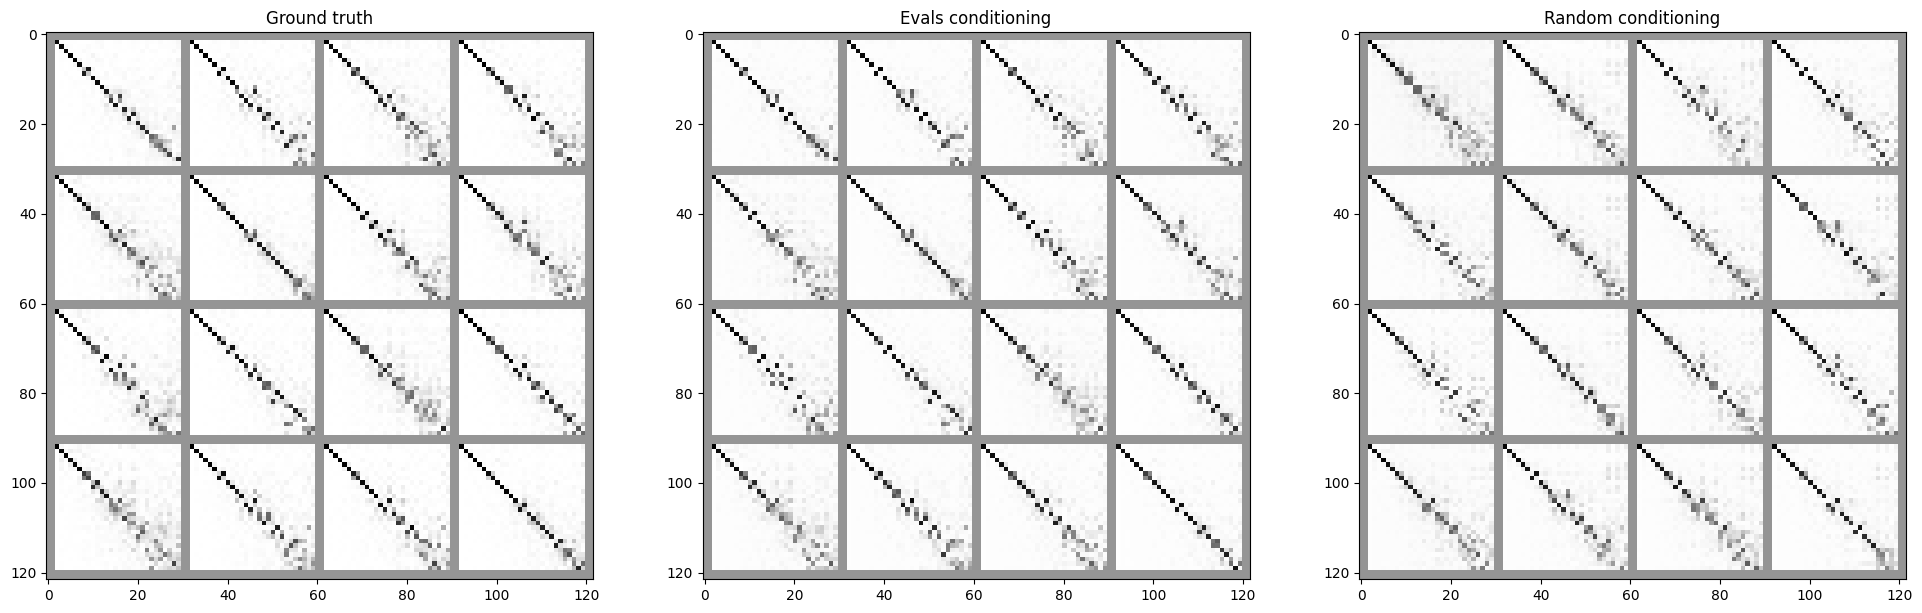

In [78]:
def conditional_loss(x_gt, x_cond, x_rand_cond):
    loss_eval = torch.tensor([])
    loss_random = torch.tensor([])
    nonzero_counts = torch.tensor([])

    for i in range(len(x_cond)):
        gt_fmap = x_gt[i][0]
        pred_fmap = x_cond[i][0]
        pred_fmap_rand = x_rand_cond[i][0]
        
        nonzero_count = (gt_fmap > -0.9).int().sum()
        nonzero_counts = torch.cat((nonzero_counts, nonzero_count.view(1)))
        
        loss_fmap = (gt_fmap - pred_fmap).abs().sum()
        loss_fmap_rand = (gt_fmap - pred_fmap_rand).abs().sum()
        
        loss_eval = torch.cat((loss_eval, loss_fmap.view(1)))
        loss_random = torch.cat((loss_random, loss_fmap_rand.view(1)))
        
    print(f'Sum across image')
    print(f'Loss sum: {torch.sum(loss_eval):.4f}, mean: {torch.mean(loss_eval):.4f}')
    print(f'Random loss sum: {torch.sum(loss_random):.4f}, mean: {torch.mean(loss_random):.4f}')
    
    print(f'Divided by nonzero count')
    print(f'Loss sum: {torch.sum(loss_eval / nonzero_counts):.4f}, mean: {torch.mean(loss_eval / nonzero_counts):.4f}')
    print(f'Random loss sum: {torch.sum(loss_random / nonzero_counts):.4f}, mean: {torch.mean(loss_random / nonzero_counts):.4f}')
    


def conditional_sampling(model, rand_indices):

    print(f"Sampling {len(rand_indices)} random fmaps")

    x_gt = torch.stack([test_dataset[i][0] for i in rand_indices])
    y_gt = torch.stack([test_dataset[i][1] for i in rand_indices])
    y_rand = torch.randn_like(y_gt)

    x_cond = sample_model(model, len(rand_indices), conditioning=y_gt, plot_last_steps=False).detach().cpu()
    x_rand_cond = sample_model(model, len(rand_indices), conditioning=y_rand, plot_last_steps=False).detach().cpu()


    conditional_loss(x_gt, x_cond, x_rand_cond)



    fig, ax = plt.subplots(1, 3, figsize=(24, 8))

    ax_0 = ax[0].imshow(torchvision.utils.make_grid(
        x_gt[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[0].set_title('Ground truth')

    ax_1 = ax[1].imshow(torchvision.utils.make_grid(
        x_cond[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[1].set_title('Evals conditioning')

    ax_2 = ax[2].imshow(torchvision.utils.make_grid(
        x_rand_cond[:16], nrow=4, value_range=(-1, 1)#, scale_each=True
        )[0], cmap='Greys')

    ax[2].set_title('Random conditioning')

    plt.show()
    
    return x_gt, x_cond, x_rand_cond
    
    
rand_indices = np.random.choice(len(test_dataset), 1024, replace=False)
x_gt, x_cond_encoder, x_rand_cond = conditional_sampling(model_conditional, rand_indices)

In [ ]:
max_loss = torch.argmax(loss_eval)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax_0 = ax[0].imshow(x_gt[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_cond[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(x_rand_cond[max_loss][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
plt.colorbar(ax_2, ax=ax[2])

plt.show()

In [ ]:
inc_inx = count_zero_regions(x_cond, -0.7, 0.2)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rand_idx = np.random.choice(inc_inx, 3, replace=False)

ax_0 = ax[0].imshow(x_cond[rand_idx[0]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_0, ax=ax[0])

ax_1 = ax[1].imshow(x_cond[rand_idx[1]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_1, ax=ax[1])

ax_2 = ax[2].imshow(x_cond[rand_idx[2]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
fig.colorbar(ax_2, ax=ax[2])

plt.show()

In [74]:
def plot_sampling_difference(x_gt, x_cond, idx):
        
    fig, ax = plt.subplots(3, 3, figsize=(10, 8))

    for i in range(3):
        ax[i, 0].imshow(x_gt[idx[i]][0].numpy(), cmap='Greys', vmin=-1, vmax=1)
        ax[i, 0].set_title('Ground truth')
        
        ax[i, 1].imshow(x_cond[idx[i]][0].cpu().numpy(), cmap='Greys', vmin=-1, vmax=1)
        ax[i, 1].set_title('Evals conditioning')
        
        difference = x_gt[idx[i]][0] - x_cond[idx[i]][0].cpu()
        ax_2 = ax[i, 2].imshow(difference.abs().numpy(),
                        cmap='Greys', vmin=0)
        plt.colorbar(ax_2, ax=ax[i, 2])
        ax[i, 2].set_title(f'Difference {difference.min():.2f} {difference.max():.2f}, {difference.abs().mean():.2f}, {difference.abs().sum():.2f}')
        
        # set suptitle 
        
        
    plt.show()

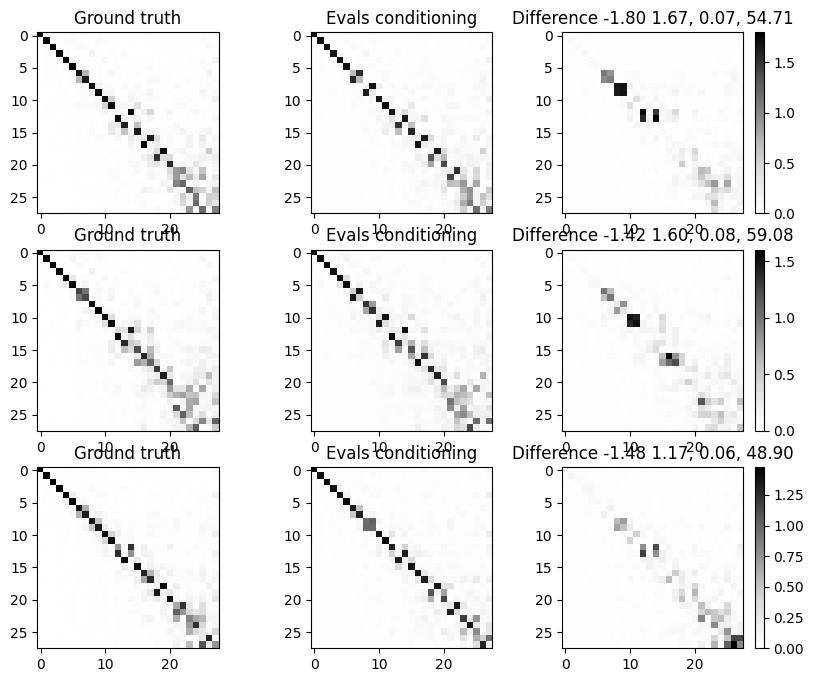

In [75]:
rand_idx = np.random.choice(len(x_gt), 3, replace=False)
plot_sampling_difference(x_gt, x_cond_encoder, rand_idx)

# Conditioning through concatenation

  0%|          | 0/25 [00:00<?, ?it/s]

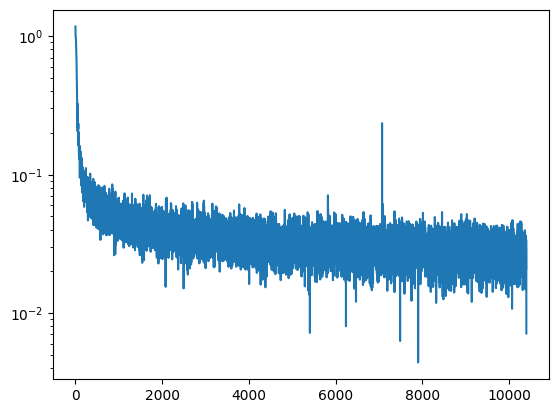

In [57]:
class DiagConditionedUnet(nn.Module):
  def __init__(self):
    super().__init__()

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=28,           # the target image resolution
        in_channels=2, # Additional input channels for class cond.
        out_channels=1,           # the number of output channels
        layers_per_block=2,       # how many ResNet layers to use per UNet block
        block_out_channels=(32, 64, 64),
        down_block_types=(
            "DownBlock2D",        # a regular ResNet downsampling block
            "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
            "AttnDownBlock2D",
        ),
        up_block_types=(
            "AttnUpBlock2D",
            "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",          # a regular ResNet upsampling block
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, sample, timestep, encoder_hidden_states):

    conditioning_diag = torch.diag_embed(encoder_hidden_states) # (bs, 28, 28

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((sample, conditioning_diag), 1) # (bs, 5, 28, 28)

    # Feed this to the UNet alongside the timestep and return the prediction
    return self.model(net_input, timestep) # (bs, 1, 28, 28)
  
  
model_diag_conditional = DiagConditionedUnet().to(device)

model_diag_conditional, losses = train_model(
    model=model_diag_conditional, n_epochs=25, loss_fn=nn.MSELoss(), is_unconditional=False
    )

plt.plot(losses)
plt.yscale('log')

plt.show()
  

Sampling 1024 random fmaps


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sum across image
Loss sum: 40360.5234, mean: 39.4146
Random loss sum: 190508.9375, mean: 186.0439
Divided by nonzero count
Loss sum: 213.3902, mean: 0.2084
Random loss sum: 1035.2632, mean: 1.0110


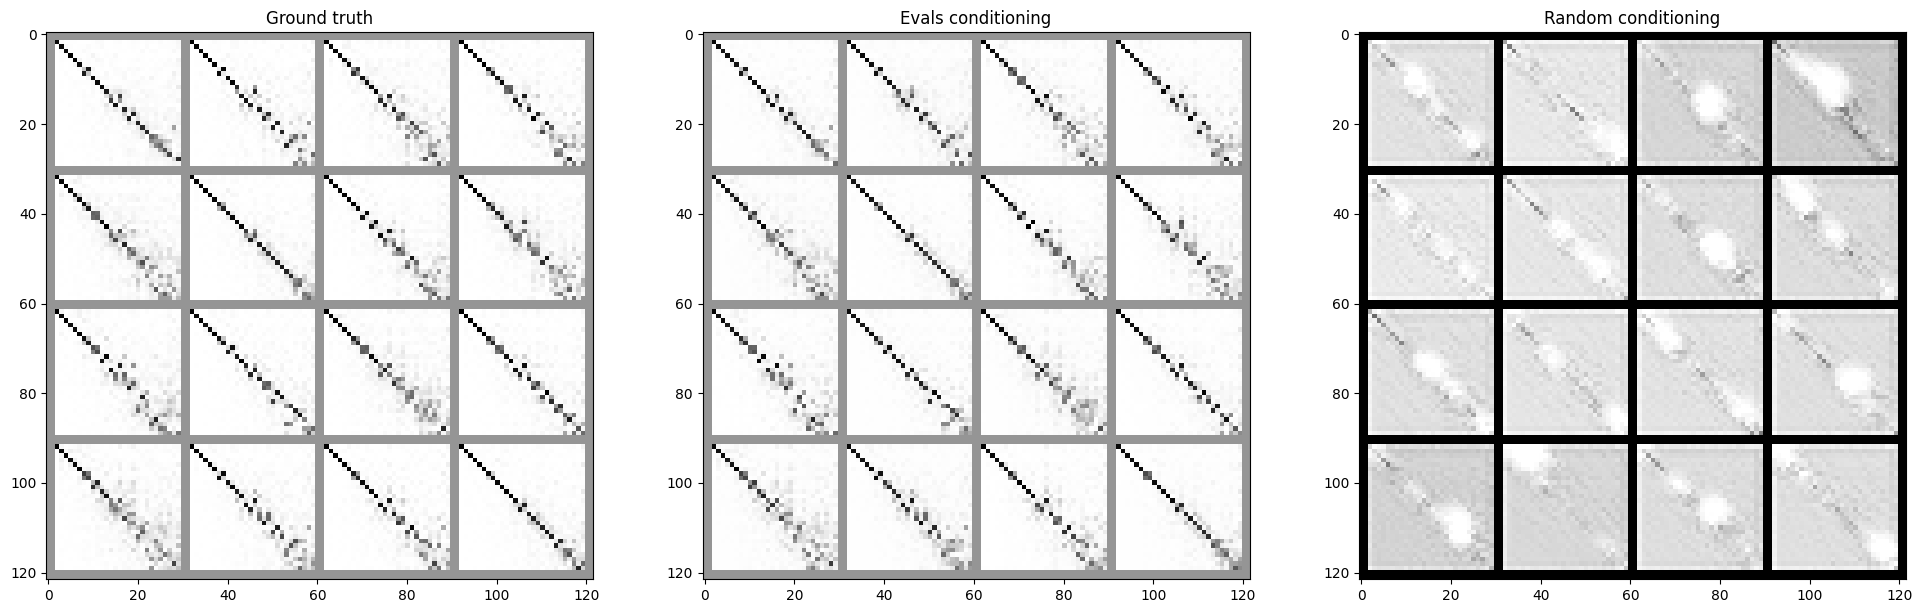

In [79]:
x_gt, x_cond_diag, x_rand_cond_diag = conditional_sampling(model_diag_conditional, rand_indices)

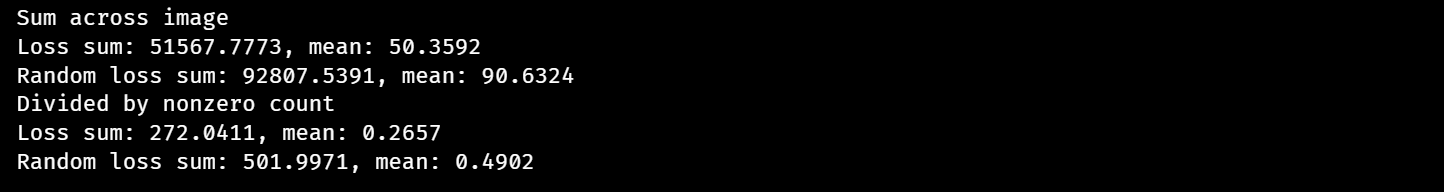

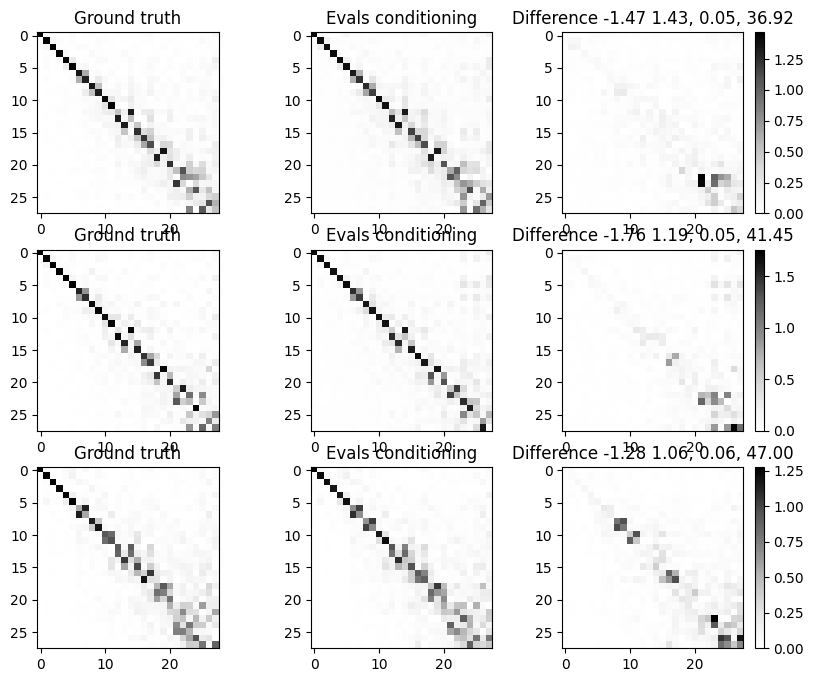

In [80]:
plot_sampling_difference(x_gt, x_cond_diag, rand_idx)